# Partially Monotonic Neural Network - Daniels, Velikova 2010

## 0. Library imports

In [1]:
# linear algebra
import math
import numpy as np

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F

# display
from torchview import draw_graph
from IPython.display import display
from IPython.core.display import SVG, HTML

# plot
import matplotlib.pyplot as plt
import matplotlib

# progress bar
from tqdm import tqdm

# model
from models.minmax2 import MonotonicNet

# functions
from functions import *

# support for automatic reloading
%load_ext autoreload
%autoreload 2

## 1. Function Examples

### $f(x) = (x+1)^2$ monotonic increasing in $x$

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_32073/2770338551.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z1_tensor = torch.tensor(f1(X_tensor_f1)).float()


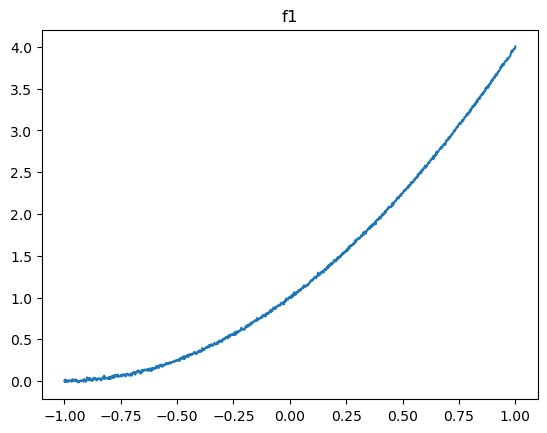

In [2]:
# define space
X_tensor_f1 = torch.linspace(-1, 1, 1000).float()
Z1_tensor = torch.tensor(f1(X_tensor_f1)).float()

# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f1.cpu().detach(), Z1_tensor.cpu().detach(), label='f1')
plt.title('f1')
plt.show()

In [3]:
# NN parameters
n_features_in = 1 # only one variable
group_sizes = [[4, 3, 3]] # number of neurons in each group
increasing_bool = [True] # indices of nonnegative connections

# increasing = [True] # increasing or decreasing
monotonic_bool = [True]
# initial learning rate

LR = 1e-3

# defining the model
model_f1 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool, n_hidden=1)

# defining the loss function, the optimizer and the scheduler
criterion_f1 = nn.MSELoss()
optimizer_f1 = torch.optim.Adam(model_f1.parameters(), lr=LR)
scheduler_f1 = torch.optim.lr_scheduler.StepLR(optimizer_f1, step_size=100, gamma=0.75)

n_samples_train = X_tensor_f1.shape[0]

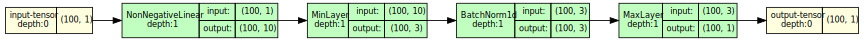

In [4]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f1, input_size=(100, n_features_in), graph_name=model_f1.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [5]:
# training loop
EPOCHS = 500
BATCH_SIZE = 10

losses_f1 = []

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f1.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_f1[idx], Z1_tensor[idx]

        # zero grad
        optimizer_f1.zero_grad()

        # forward pass
        output = model_f1(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f1(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f1.step()

    # update LR
    scheduler_f1.step()

    losses_f1.append(np.mean(train_losses))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f1[-1]:.7f} - LR {optimizer_f1.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:48<00:00, 10.42it/s, Loss 0.1668209 - LR 0.0002373]


Epoch 500 - train loss: 0.1668209107685834
Epoch 500 - test loss: 0.02489999495446682


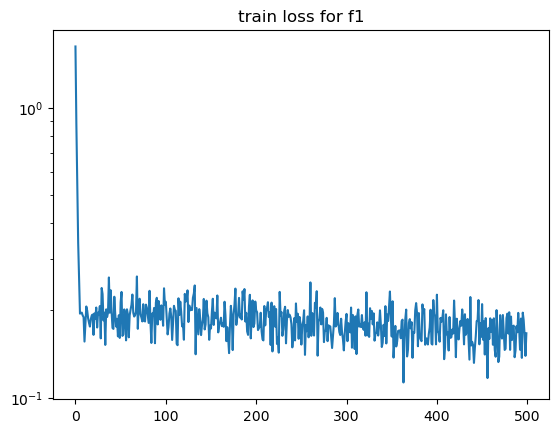

In [6]:
# prediction
with torch.no_grad():
    model_f1.eval()
    y_pred = model_f1(X_tensor_f1.unsqueeze(1))

final_loss = criterion_f1(y_pred, Z1_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f1[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f1, label='train loss')
plt.yscale('log')
plt.title('train loss for f1')
# plt.savefig('figures/train_loss_f1.png')
plt.show()

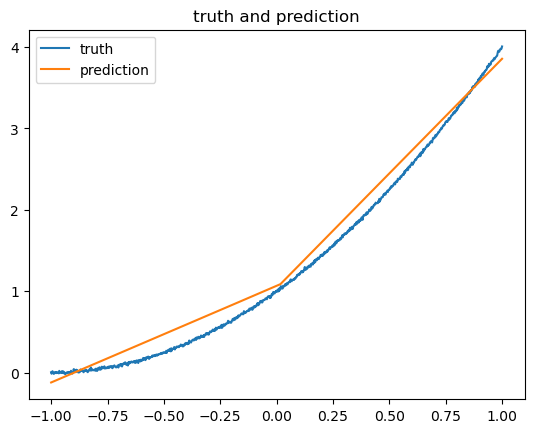

In [7]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f1, Z1_tensor, label='truth')
plt.plot(X_tensor_f1, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
# plt.savefig('figures/truth_prediction_f1.png')
plt.show()

### 2.2 $f(x) = -(x+1)^2$: monotonic decreasing in $x$

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_32073/1942353590.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z2_tensor = torch.tensor(f2(X_tensor_f2)).float()


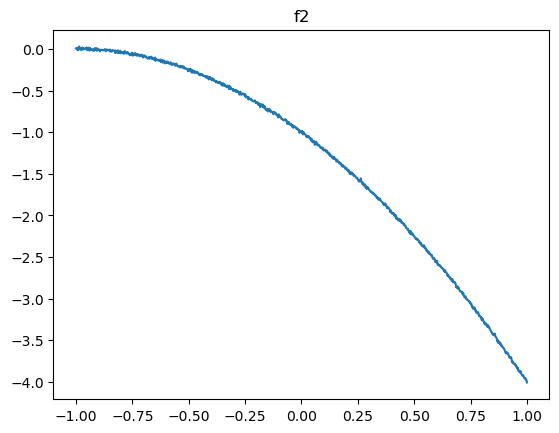

In [8]:
# define space
X_tensor_f2 = torch.linspace(-1, 1, 1000).float()
Z2_tensor = torch.tensor(f2(X_tensor_f2)).float()

# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f2.cpu().detach(), Z2_tensor.cpu().detach(), label='f2')
plt.title('f2')
# plt.savefig('figures/f2.png')
plt.show()

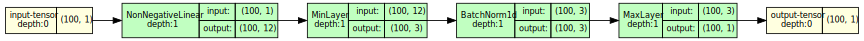

In [9]:
# NN parameters
n_features_in = 1 # only one variable
group_sizes = [[2, 5, 5]] # number of neurons in each group
increasing_bool = [False] # indices of nonnegative connections

# increasing = [True] # increasing or decreasing
monotonic_bool = [True]

# initial learning rate
LR = 1e-3

# defining the model
model_f2 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool)

# defining the loss function, the optimizer and the scheduler
criterion_f2 = nn.MSELoss()
optimizer_f2 = torch.optim.Adam(model_f2.parameters(), lr=LR)
scheduler_f2 = torch.optim.lr_scheduler.StepLR(optimizer_f2, step_size=50, gamma=0.75)

n_samples_train = X_tensor_f2.shape[0]

# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f2, input_size=(100, n_features_in), graph_name=model_f2.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [10]:
# training loop
EPOCHS = 200
BATCH_SIZE = 10

losses_f2 = []

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f2.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_f2[idx], Z2_tensor[idx]

        # zero grad
        optimizer_f2.zero_grad()

        # forward pass
        output = model_f2(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f2(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f2.step()

    # update LR
    scheduler_f2.step()

    losses_f2.append(np.mean(train_losses))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f2[-1]:.7f} - LR {optimizer_f2.param_groups[0]['lr']:.7f}")
    

Epoch 199: 100%|██████████| 200/200 [00:20<00:00,  9.78it/s, Loss 0.1759554 - LR 0.0003164]


Epoch 200 - train loss: 0.17595542629016564
Epoch 200 - test loss: 0.022829527035355568


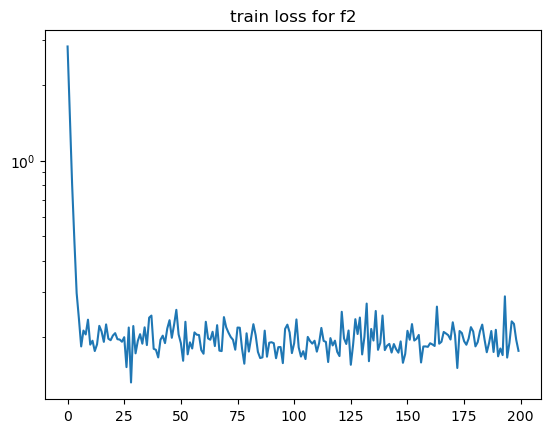

In [11]:
# prediction
with torch.no_grad():
    model_f2.eval()
    y_pred = model_f2(X_tensor_f2.unsqueeze(1))

final_loss = criterion_f2(y_pred, Z2_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f2[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f2, label='train loss')
plt.yscale('log')
plt.title('train loss for f2')
# plt.savefig('figures/train_loss_f2.png')
plt.show()

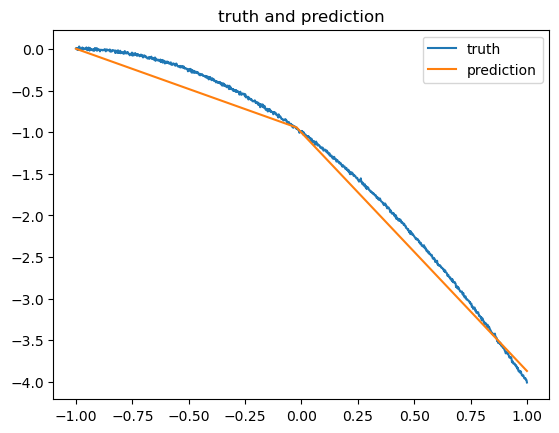

In [12]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f2, Z2_tensor, label='truth')
plt.plot(X_tensor_f2, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
# plt.savefig('figures/truth_prediction_f2.png')
plt.show()

### 2.3 $f(x, y) = x+y$: monotonic increasing in $x$ and $y$

/Users/ncarmona/miniconda3/envs/torch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454852765/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_32073/2163196853.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z3_tensor_2D = torch.tensor(f3(X_tensor_f3_2D, Y_tensor_f3_2D))
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_32073/2163196853.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than

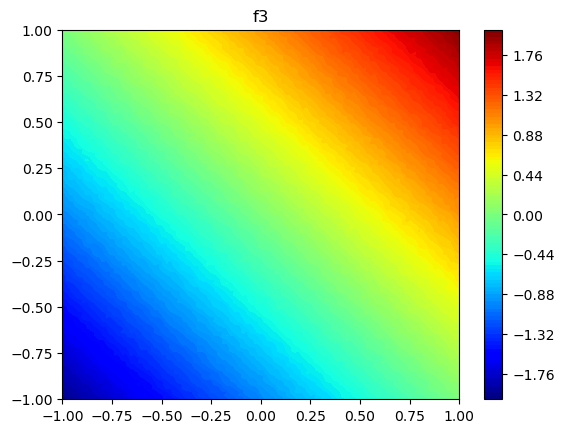

In [13]:
# define space
X_tensor_f3 = torch.linspace(-1, 1, 100)
Y_tensor_f3 = torch.linspace(-1, 1, 100)
X_tensor_f3_2D, Y_tensor_f3_2D = torch.meshgrid(X_tensor_f3, Y_tensor_f3)
Z3_tensor_2D = torch.tensor(f3(X_tensor_f3_2D, Y_tensor_f3_2D))

X_tensor_2d = torch.cat((X_tensor_f3_2D.unsqueeze(2), Y_tensor_f3_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z3_tensor = torch.tensor(Z3_tensor_2D.ravel()).float()

plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f3_2D, Y_tensor_f3_2D, Z3_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f3')
# plt.savefig('figures/f3.png')
plt.show()

In [14]:
# NN parameters
n_features_in = 2 # 
group_sizes = [[4, 3, 3]] # number of neurons in each group
increasing_bool = [True, True] # indices of nonnegative connections

# increasing = [True] # increasing or decreasing
monotonic_bool = [True, True]
# initial learning rate

LR = 1e-3

# defining the model
model_f3 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool)

# defining the loss function, the optimizer and the scheduler
criterion_f3 = nn.MSELoss()
optimizer_f3 = torch.optim.Adam(model_f3.parameters(), lr=LR)
scheduler_f3 = torch.optim.lr_scheduler.StepLR(optimizer_f3, step_size=100, gamma=0.75)

n_samples_train = X_tensor_2d.shape[0]

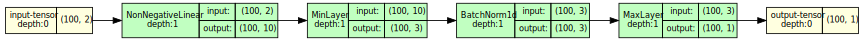

In [15]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f3, input_size=(100, n_features_in), graph_name=model_f1.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [16]:
# training loop
EPOCHS = 500
BATCH_SIZE = 256

losses_f3 = []

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f3.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_2d[idx], Z3_tensor[idx]

        # zero grad
        optimizer_f3.zero_grad()

        # forward pass
        output = model_f3(batch_x)

        # compute loss
        loss = criterion_f3(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f3.step()

    # update LR
    scheduler_f3.step()

    losses_f3.append(np.mean(train_losses))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f3[-1]:.7f} - LR {optimizer_f3.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:28<00:00, 17.34it/s, Loss 0.0038267 - LR 0.0002373]


Epoch 500 - train loss: 0.003826703069717041
Epoch 500 - test loss: 0.00036732092848978937


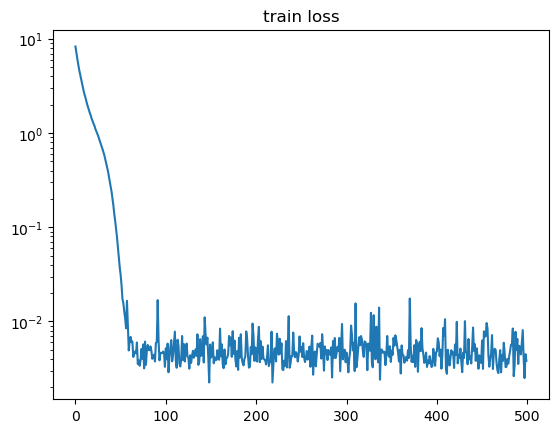

In [17]:
# prediction
with torch.no_grad():
    model_f3.eval()
    y_pred = model_f3(X_tensor_2d)

final_loss = criterion_f3(y_pred, Z3_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f3[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f3, label='train loss')
plt.yscale('log')
plt.title('train loss')
# plt.savefig('figures/train_loss_f3.png')
plt.show()

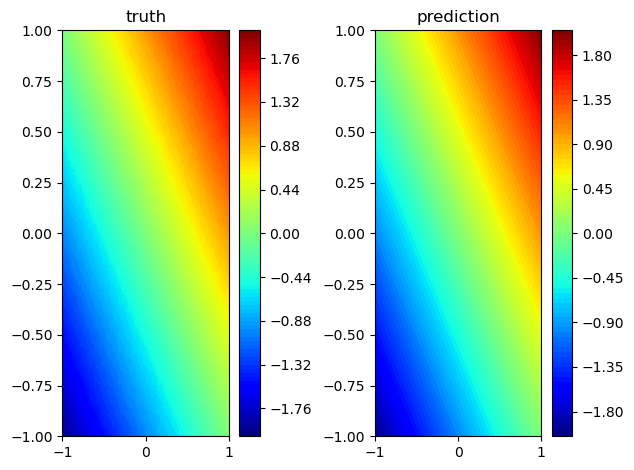

In [18]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f3_2D, Y_tensor_f3_2D, Z3_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f3_2D, Y_tensor_f3_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

# plt.savefig('figures/truth_prediction_f3.png')
plt.show()

### 2.4 $f(x, y) = x-y$: monotonic increasing in $x$, decreasing in $y$ 

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_32073/4011485104.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z4_tensor_2D = torch.tensor(f4(X_tensor_f4_2D, Y_tensor_f4_2D))
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_32073/4011485104.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z4_tensor = torch.tensor(Z4_tensor_2D.ravel()).float()


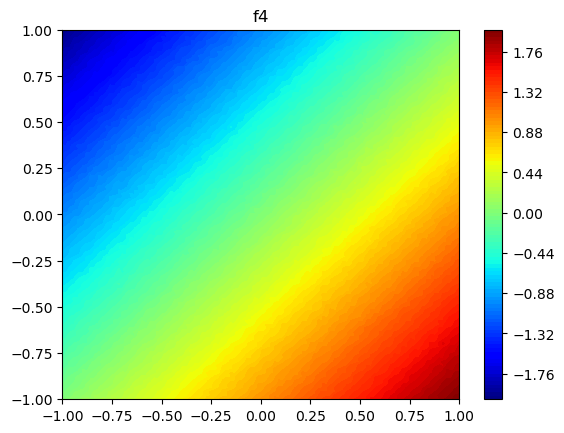

In [19]:
# define space
X_tensor_f4 = torch.linspace(-1, 1, 100)
Y_tensor_f4 = torch.linspace(-1, 1, 100)
X_tensor_f4_2D, Y_tensor_f4_2D = torch.meshgrid(X_tensor_f4, Y_tensor_f4)
Z4_tensor_2D = torch.tensor(f4(X_tensor_f4_2D, Y_tensor_f4_2D))

X_tensor_2d = torch.cat((X_tensor_f4_2D.unsqueeze(2), Y_tensor_f4_2D.unsqueeze(2)), dim=2).view(-1, 2)
Z4_tensor = torch.tensor(Z4_tensor_2D.ravel()).float()

plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f4_2D, Y_tensor_f4_2D, Z4_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f4')
# plt.savefig('figures/f4.png')
plt.show()

In [20]:
# NN parameters
n_features_in = 2
group_sizes = [[4, 3, 3, 4]] # number of neurons in each group

increasing_bool = [True, False] # indices of nonnegative connections
# increasing = [True] # increasing or decreasing
monotonic_bool = [True, True]
# initial learning rate

# initial learning rate
LR = 1e-4

# defining the model
model_f4 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool)

# defining the loss function, the optimizer and the scheduler
criterion_f4 = nn.MSELoss()
optimizer_f4 = torch.optim.Adam(model_f4.parameters(), lr=LR)
scheduler_f4 = torch.optim.lr_scheduler.StepLR(optimizer_f4, step_size=100, gamma=0.75)

n_samples_train = X_tensor_2d.shape[0]

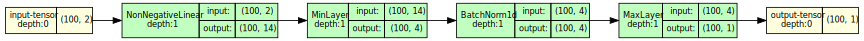

In [21]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f4, input_size=(100, n_features_in), graph_name=model_f1.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [22]:
# training loop
EPOCHS = 500
BATCH_SIZE = 256

losses_f4 = []

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f4.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_2d[idx], Z4_tensor[idx]

        # zero grad
        optimizer_f4.zero_grad()

        # forward pass
        output = model_f4(batch_x)

        # compute loss
        loss = criterion_f4(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f4.step()

    # update LR
    scheduler_f4.step()

    losses_f4.append(np.mean(train_losses))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f4[-1]:.7f} - LR {optimizer_f4.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:30<00:00, 16.15it/s, Loss 0.0038568 - LR 0.0000237]


Epoch 500 - train loss: 0.003856834959515254
Epoch 500 - test loss: 0.0003088052326347679


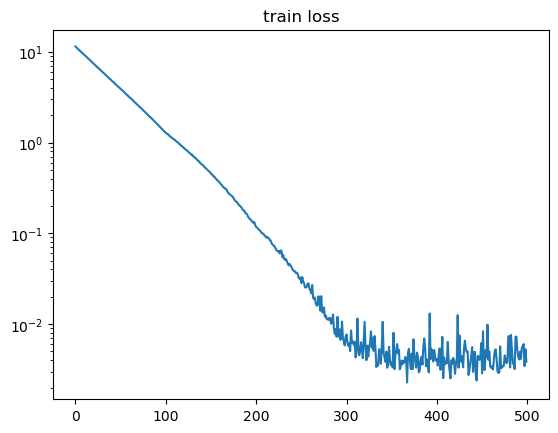

In [23]:
# prediction
with torch.no_grad():
    model_f4.eval()
    y_pred = model_f4(X_tensor_2d)

final_loss = criterion_f4(y_pred, Z4_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f4[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f4, label='train loss')
plt.yscale('log')
plt.title('train loss')
# plt.savefig('figures/train_loss_f4.png')
plt.show()

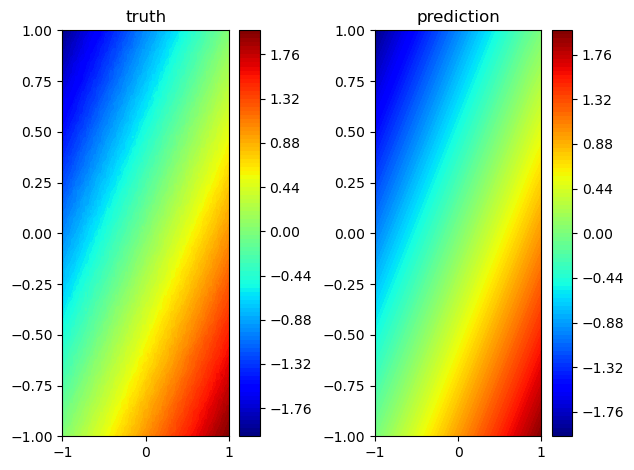

In [24]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f4_2D, Y_tensor_f4_2D, Z4_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f4_2D, Y_tensor_f4_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

# plt.savefig('figures/truth_prediction_f4.png')

plt.show()

### 2.5 $f(x) = cos(x)$: non-monotonic but concave

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_32073/1293730884.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z5_tensor = torch.tensor(f5(X_tensor_f5)).float()


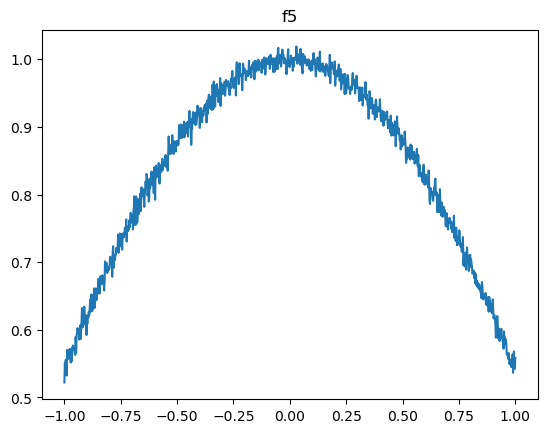

In [25]:
# define space
X_tensor_f5 = torch.linspace(-1, 1, 1000).float()
Z5_tensor = torch.tensor(f5(X_tensor_f5)).float()

# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f5.cpu().detach(), Z5_tensor.cpu().detach(), label='f5')
plt.title('f5')
# plt.savefig('figures/f5.png')
plt.show()

In [26]:
# NN parameters
n_features_in = 1 # only one variable
group_sizes = [[2, 5, 5, 2]] # number of neurons in each group
increasing_bool = [None] # indices of nonnegative connections

# increasing = [True] # increasing or decreasing
monotonic_bool = [False]
# initial learning rate

LR = 1e-3

# defining the model
model_f5 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool)

# defining the loss function, the optimizer and the scheduler
criterion_f5 = nn.MSELoss()
optimizer_f5 = torch.optim.Adam(model_f5.parameters(), lr=LR)
scheduler_f5 = torch.optim.lr_scheduler.StepLR(optimizer_f5, step_size=100, gamma=0.75)

n_samples_train = X_tensor_f5.shape[0]

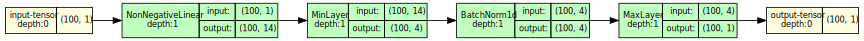

In [27]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f5, input_size=(100, n_features_in), graph_name=model_f5.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [28]:
# training loop
EPOCHS = 200
BATCH_SIZE = 10

losses_f5 = []

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f5.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_f5[idx], Z5_tensor[idx]

        # zero grad
        optimizer_f5.zero_grad()

        # forward pass
        output = model_f5(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f5(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f5.step()

    # update LR
    scheduler_f5.step()

    losses_f5.append(np.mean(train_losses))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f5[-1]:.7f} - LR {optimizer_f5.param_groups[0]['lr']:.7f}")
    

Epoch 199: 100%|██████████| 200/200 [00:19<00:00, 10.01it/s, Loss 0.0030048 - LR 0.0005625]


Epoch 200 - train loss: 0.0030048187733336816
Epoch 200 - test loss: 0.00043054617708548903


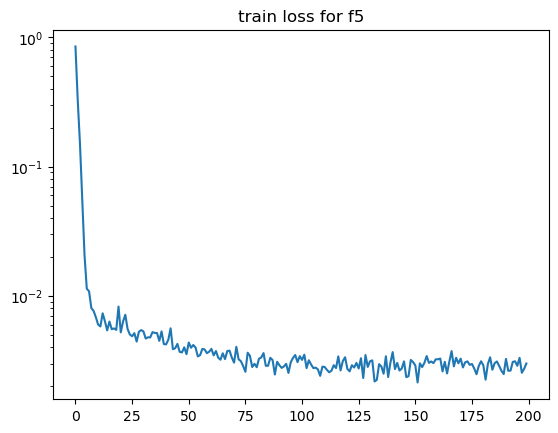

In [29]:
# prediction
with torch.no_grad():
    model_f5.eval()
    y_pred = model_f5(X_tensor_f5.unsqueeze(1))

final_loss = criterion_f5(y_pred, Z5_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f5[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f5, label='train loss')
plt.yscale('log')
plt.title('train loss for f5')
# plt.savefig('figures/train_loss_f5.png')
plt.show()

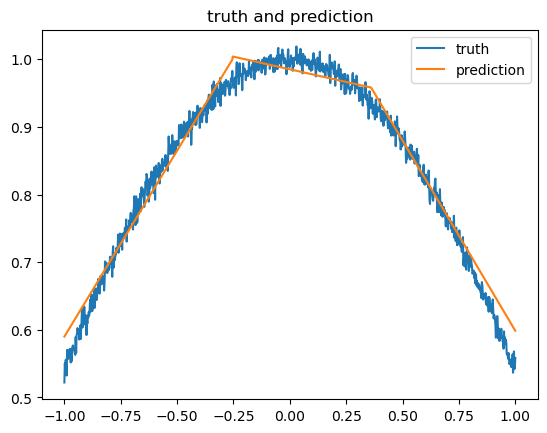

In [30]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f5, Z5_tensor, label='truth')
plt.plot(X_tensor_f5, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
# plt.savefig('figures/truth_prediction_f5.png')
plt.show()

### 2.6 $f(x, y) = x^3 + 0.5*sin(4*\pi*y)$: monotonic increasing in $x$ and non-monotonic in $y$

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_32073/3412706833.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z6_tensor_2D = torch.tensor(f6(X_tensor_f6_2D, Y_tensor_f6_2D))
/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_32073/3412706833.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z6_tensor = torch.tensor(Z6_tensor_2D.ravel()).float()


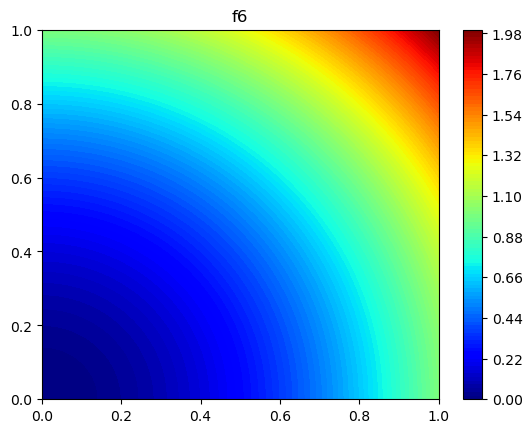

In [46]:
# define space
X_tensor_f6 = torch.linspace(0, 1, 100)
Y_tensor_f6 = torch.linspace(0, 1, 100)
X_tensor_f6_2D, Y_tensor_f6_2D = torch.meshgrid(X_tensor_f6, Y_tensor_f6)
Z6_tensor_2D = torch.tensor(f6(X_tensor_f6_2D, Y_tensor_f6_2D))

X_tensor_2d = torch.cat((X_tensor_f6_2D.unsqueeze(2), Y_tensor_f6_2D.unsqueeze(2)), dim=1).view(-1, 2)
Z6_tensor = torch.tensor(Z6_tensor_2D.ravel()).float()

# Z6_tensor = (Z6_tensor - torch.min(Z6_tensor))/ (torch.max(Z6_tensor) - torch.min(Z6_tensor))

# plotting the function
plt.subplot(1, 1, 1)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, Z6_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('f6')
# plt.savefig('figures/f6.png')
plt.show()

In [47]:
# NN parameters
n_features_in = 2 # only one variable
group_sizes = [[8, 8, 8, 8]] # number of neurons in each group
increasing_bool = [True, True] # indices of nonnegative connections
n_hidden = 1
hidden_size = [16, 16]
# increasing = [True] # increasing or decreasing
monotonic_bool = [True, True]

# initial learning rate
LR = 1e-2

# defining the model
model_f6 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool, n_hidden=n_hidden, hidden_size=hidden_size)

# defining the loss function, the optimizer and the scheduler
criterion_f6 = nn.MSELoss()
optimizer_f6 = torch.optim.Adam(model_f6.parameters(), lr=LR)
scheduler_f6 = torch.optim.lr_scheduler.StepLR(optimizer_f6, step_size=100, gamma=0.75)
# cosine scheduler
# scheduler_f6 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_f6, T_max=100, eta_min=1e-6)
n_samples_train = X_tensor_2d.shape[0]

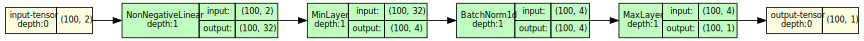

In [48]:
# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f6, input_size=(100, n_features_in), graph_name=model_f6.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [49]:
# training loop
EPOCHS = 500
BATCH_SIZE = 256

losses_f6 = []

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f6.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_2d[idx], Z6_tensor[idx]

        # zero grad
        optimizer_f6.zero_grad()

        # forward pass
        output = model_f6(batch_x)

        # compute loss
        loss = criterion_f6(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f6.step()

    # update LR
    scheduler_f6.step()

    losses_f6.append(np.mean(train_losses))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f6[-1]:.7f} - LR {optimizer_f6.param_groups[0]['lr']:.7f}")
    

Epoch 499: 100%|██████████| 500/500 [00:31<00:00, 15.98it/s, Loss 0.0538371 - LR 0.0023730]


Epoch 500 - train loss: 0.0538371192291379
Epoch 500 - test loss: 0.05308312922716141


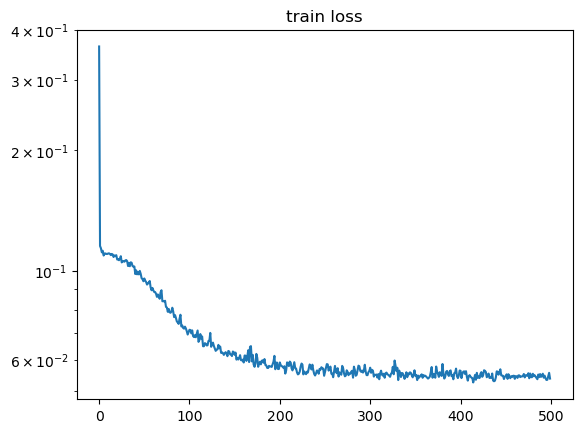

In [50]:
# prediction
with torch.no_grad():
    model_f6.eval()
    y_pred = model_f6(X_tensor_2d)

final_loss = criterion_f6(y_pred, Z6_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f6[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f6, label='train loss')
plt.yscale('log')
plt.title('train loss')
# plt.savefig('figures/train_loss_f6.png')
plt.show()

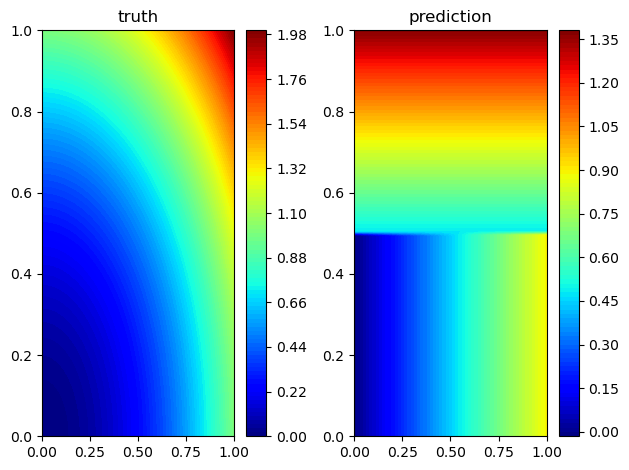

In [36]:
# plot truth and prediction side by side
plt.subplot(1, 2, 1)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, Z6_tensor_2D, 100, cmap='jet')
plt.colorbar()
plt.title('truth')

plt.subplot(1, 2, 2)
plt.contourf(X_tensor_f6_2D, Y_tensor_f6_2D, y_pred.view(100, 100).detach().numpy(), 100, cmap='jet')
plt.colorbar()
plt.title('prediction')

plt.tight_layout()

# plt.savefig('figures/truth_prediction_f6.png')
plt.show()

### 2.7 

/var/folders/28/h_mscv5s3451k1q3hj4p2gxm0000gn/T/ipykernel_32073/2138200167.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Z7_tensor = torch.tensor(f7(X_tensor_f7)).float()


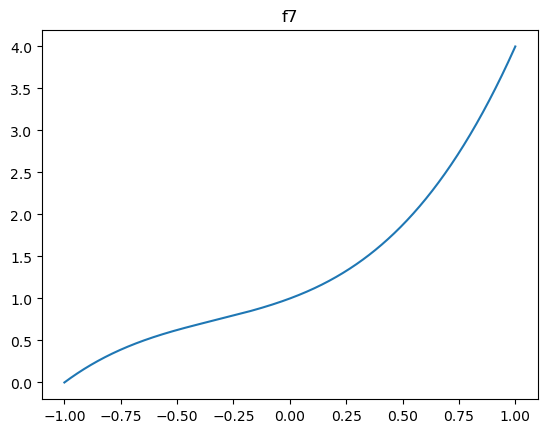

In [37]:
# define space
X_tensor_f7 = torch.linspace(-1, 1, 1000).float()
Z7_tensor = torch.tensor(f7(X_tensor_f7)).float()

# plotting the function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f7.cpu().detach(), Z7_tensor.cpu().detach(), label='f7')
plt.title('f7')
# plt.savefig('figures/f2.png')
plt.show()

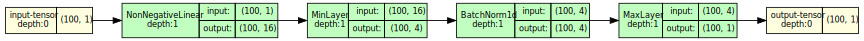

In [38]:
# NN parameters
n_features_in = 1 # only one variable
group_sizes = [[4, 4, 4, 4]] # number of neurons in each group
increasing_bool = [True] # indices of nonnegative connections

# increasing = [True] # increasing or decreasing
monotonic_bool = [True]

# initial learning rate
LR = 1e-3

# defining the model
model_f7 = MonotonicNet(in_features=n_features_in, group_sizes=group_sizes, nonnegative_bool=increasing_bool, monotonic_bool=monotonic_bool)

# defining the loss function, the optimizer and the scheduler
criterion_f7 = nn.MSELoss()
optimizer_f7 = torch.optim.Adam(model_f7.parameters(), lr=LR)
scheduler_f7 = torch.optim.lr_scheduler.StepLR(optimizer_f7, step_size=50, gamma=0.75)

n_samples_train = X_tensor_f7.shape[0]

# Show model
try:
    from torchview import draw_graph
    from IPython.core.display import SVG
except ImportError as e:
    print(f"Install graphviz and torchview to show model graph: {e.msg}")
    graph = None
else:
    model_graph = draw_graph(model_f7, input_size=(100, n_features_in), graph_name=model_f7.__class__.__name__, device='cpu', graph_dir="LR")
    graph = SVG(model_graph.visual_graph._repr_image_svg_xml())
graph

In [39]:
# training loop
EPOCHS = 200
BATCH_SIZE = 10

losses_f7 = []

for epoch in (pbar := tqdm(range(EPOCHS))):
# for epoch in range(EPOCHS):
    train_losses = []
    permutation = torch.randperm(n_samples_train)
    for i in range(0, n_samples_train, BATCH_SIZE):
        model_f7.train()

        # choose batch
        idx = permutation[i: i+BATCH_SIZE] # np.arange(i, i+BATCH_SIZE)
        batch_x, batch_y = X_tensor_f7[idx], Z7_tensor[idx]

        # zero grad
        optimizer_f7.zero_grad()

        # forward pass
        output = model_f7(batch_x.unsqueeze(1))

        # compute loss
        loss = criterion_f7(output, batch_y.unsqueeze(1))

        # backward pass
        loss.backward()
        train_losses.append(loss.item())

        # update weights
        optimizer_f7.step()

    # update LR
    scheduler_f7.step()

    losses_f7.append(np.mean(train_losses))

    pbar.set_description(f"Epoch {epoch: >2}")
    pbar.set_postfix_str(f"Loss {losses_f7[-1]:.7f} - LR {optimizer_f7.param_groups[0]['lr']:.7f}")
    

Epoch 199: 100%|██████████| 200/200 [00:22<00:00,  9.08it/s, Loss 0.1397395 - LR 0.0003164]


Epoch 200 - train loss: 0.13973945225588977
Epoch 200 - test loss: 0.00857916846871376


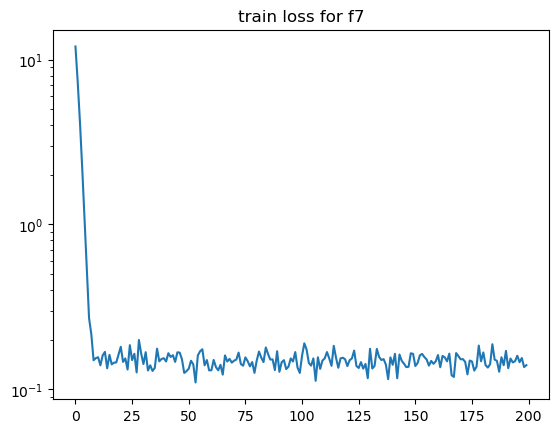

In [40]:
# prediction
with torch.no_grad():
    model_f7.eval()
    y_pred = model_f7(X_tensor_f7.unsqueeze(1))

final_loss = criterion_f7(y_pred, Z7_tensor.unsqueeze(1))

print(f"Epoch {EPOCHS} - train loss: {losses_f7[-1]}")
print(f"Epoch {EPOCHS} - test loss: {final_loss}")

# plot train loss
plt.subplot(1, 1, 1)
plt.plot(losses_f7, label='train loss')
plt.yscale('log')
plt.title('train loss for f7')
# plt.savefig('figures/train_loss_f2.png')
plt.show()

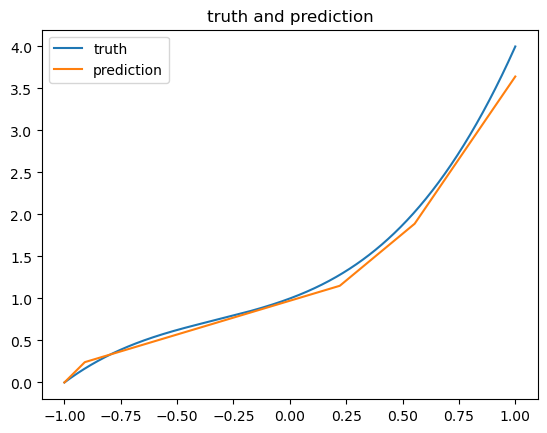

In [41]:
# plot truth and prediction on same graph for 1D function
plt.subplot(1, 1, 1)
plt.plot(X_tensor_f7, Z7_tensor, label='truth')
plt.plot(X_tensor_f7, y_pred, label='prediction')
plt.title('truth and prediction')
plt.legend()
# plt.savefig('figures/truth_prediction_f2.png')
plt.show()